In [217]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

plt.rcParams['figure.figsize'] = (6, 6)
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['figure.titlesize'] = 14
plt.rcParams['axes.titlesize'] = 12

%matplotlib inline

In [184]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    
    custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
    plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "g.", alpha=0.1)
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "b.", alpha=0.1)
        plt.axis(axes)
    
    if legend:
        plt.legend(loc="lower right", fontsize=14)

### Exercise 7. Train and fine-tune a decision tree for the moons dataset

#### a. Load data

In [75]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=10000, noise=0.4, random_state=42)

In [76]:
X.shape

(10000, 2)

In [77]:
pd.value_counts(y)

1    5000
0    5000
dtype: int64

In [78]:
y[:10]

array([1, 0, 0, 0, 0, 1, 0, 1, 1, 0])

#### b. Split train and test

In [79]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

#### c. grid search with cv

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [186]:
clf = DecisionTreeClassifier(random_state=19)

param_grids = [{"criterion": ["gini", "entropy"], 
              "min_samples_leaf": list(range(2, 20, 2)), 
               "max_leaf_nodes": list(range(2, 50))}]

grid_cv = GridSearchCV(clf, param_grids, scoring='accuracy', refit=True, cv=4, verbose=1)

In [187]:
grid_results = grid_cv.fit(X_train, y_train)

Fitting 4 folds for each of 864 candidates, totalling 3456 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3456 out of 3456 | elapsed:   28.8s finished


In [188]:
grid_results.best_score_

0.8543999999999999

In [193]:
pd.DataFrame(grid_results.cv_results_)[['rank_test_score', 'params', 'mean_test_score', 'std_test_score']].sort_values('rank_test_score')[:5]

,rank_test_score,params,mean_test_score,std_test_score
63,1,"{'criterion': 'gini', 'max_leaf_nodes': 9, 'min_samples_leaf': 2}",0.8544,0.0079
52,1,"{'criterion': 'gini', 'max_leaf_nodes': 7, 'min_samples_leaf': 16}",0.8544,0.0079
51,1,"{'criterion': 'gini', 'max_leaf_nodes': 7, 'min_samples_leaf': 14}",0.8544,0.0079
50,1,"{'criterion': 'gini', 'max_leaf_nodes': 7, 'min_samples_leaf': 12}",0.8544,0.0079
49,1,"{'criterion': 'gini', 'max_leaf_nodes': 7, 'min_samples_leaf': 10}",0.8544,0.0079


In [194]:
grid_results.best_params_

{'criterion': 'gini', 'max_leaf_nodes': 4, 'min_samples_leaf': 2}

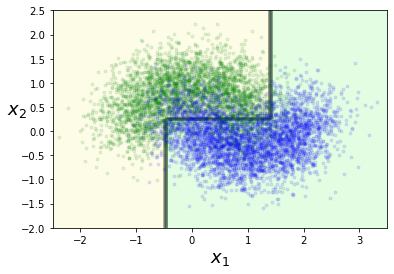

In [195]:
plot_decision_boundary(best_tree, X_train, y_train, axes=[-2.5, 3.5, -2, 2.5])

#### d. test accracy

In [196]:
best_tree = grid_results.best_estimator_
y_predict = best_tree.predict(X_test)
accuracy_score(y_test, y_predict)

0.8636

### Exercise 8. Grow a forest

#### a. Generate 1000 subsets of training set

In [197]:
from sklearn.model_selection import ShuffleSplit

rs = ShuffleSplit(n_splits = 1000, train_size=100, random_state=12)

#### b. Train 1000 trees with only 100 observations per tree

In [211]:
clf = DecisionTreeClassifier(**grid_results.best_params_)
y_pred_per_tree = []
accuracy_list = []

for train_idx, _ in rs.split(X_train):
    clf.fit(X_train[train_idx], y_train[train_idx])
    y_predict = clf.predict(X_test)
    accuracy_list.append(accuracy_score(y_test, y_predict))
    y_pred_per_tree.append(y_predict)

In [212]:
pd.Series(accuracy_list).describe()

count    1000.0000
mean        0.8269
std         0.0294
min         0.6988
25%         0.8096
50%         0.8322
75%         0.8520
max         0.8684
dtype: float64

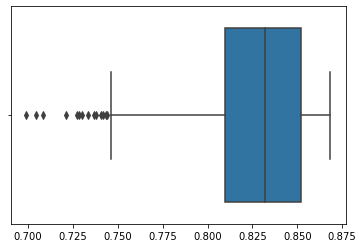

In [213]:
sns.boxplot(pd.Series(accuracy_list))

#### c. majority vote

In [214]:
from scipy.stats import mode
get_mode = lambda x: mode

In [215]:
y_predict_most_freq = mode(np.c_[y_pred_per_tree], axis=0)[0][0] # each col is one test instance; each row is output from one tree

In [216]:
accuracy_score(y_test, y_predict_most_freq)

0.864